# AGUA : Automated Genotyping using Unsupervised Algorithm 
## training pipeline Python script
### Diego Frias, 08.10.2023

In [2]:
#import our three important packages
#!/usr/bin/env python
# -*- coding: utf-8 -*-
import os
import sys
import Bio as Bio
from Bio import SeqIO
from Bio import AlignIO

import time as time
import numpy as np

from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, to_tree
from scipy.spatial.distance import squareform

import pandas as pd
import random

import dill # for model object handling
from Bio import Phylo
from Bio.Phylo.TreeConstruction import DistanceMatrix, DistanceTreeConstructor
from Bio.Phylo.BaseTree import Clade as Clade
from Bio.Phylo.BaseTree import Tree as BioTree
from collections import defaultdict

from ete3 import Tree, TreeStyle


# FASE 1 - PREPROCESSAMENTO
## LEITURA DO DATASET DE TREINAMENTO & IDENTIFICAÇÃO/CODIFICAÇÃO DE CLASSES PRIMÁRIAS

In [3]:
base = [16, 4, 1]

nucleotides = {
"A": 0,
"G": 1,
"C": 2,
"T": 3,
"a": 0,
"g": 1,
"c": 2,
"t": 3,
}

stops=["TAA","TAG","TGA"]

stopnmb=[]

for triplet in stops:
    codonNumber = 0 # 0 to 63
    for p in range(3):
          codonNumber += base[p] * nucleotides[triplet[p]]
    stopnmb.append(codonNumber)

print("stop codon ordinals ",stopnmb)

stop codon ordinals  [48, 49, 52]


In [4]:
#import the sequences we will use. These are 16s sequences from GenBank
#example: https://www.ncbi.nlm.nih.gov/nuccore/FJ039971.1?report=genbank

# fname = "spike_alingment.fas" # PROVA DE CONCEITO
fname = "/home/m_souza/tcc/dataset/dataset_agua/sequencias_treinamento.fasta" # CASO REAL
# fname = "spike_alingment.fas"
# t1 = SeqIO.read("sequence1.fasta", "fasta")
# t2 = SeqIO.read("sequence2.fasta", "fasta")
# t3 = SeqIO.read("sequence3.fasta", "fasta")
# t4 = SeqIO.read("sequence4.fasta", "fasta")
# t5 = SeqIO.read("sequence5.fasta", "fasta")
# t6 = SeqIO.read("sequence6.fasta", "fasta")
# t7 = SeqIO.read("sequence7.fasta", "fasta")

t=[]
with open(fname) as handle:
    for values in SeqIO.FastaIO.SimpleFastaParser(handle):
        t.append(values)
        print(t[-1][0])

Nseq=len(t)

print("number of sequences in file ",fname," = ",Nseq)

spike_OM056186
spike_OM058922
spike_OM059019
spike_OM059033
spike_OM059246
spike_OM065541
spike_OM065547
spike_OM065569
spike_OM065570
spike_OM065572
spike_OM065582
spike_OM065584
spike_OM065586
spike_OM065603
spike_OM065661
spike_OM065662
spike_OM065665
spike_OM065677
spike_OM065684
spike_OM065682
spike_OM065685
spike_OM065686
spike_OM065688
spike_OM065691
spike_OM065696
spike_OM065709
spike_OM065712
spike_OM065714
spike_OM036675
spike_OM036870
spike_OM036966
spike_OM038376
spike_OM116753
spike_OM133912
spike_OM117210
spike_OM117387
spike_OM135128
spike_OM135237
spike_OM136750
spike_OM136922
spike_OM122019
spike_OM125506
spike_OM126138
spike_OM127121
spike_OL919777
spike_OM103723
spike_OM173411
spike_OM173719
spike_OM173785
spike_OM174072
spike_OM155060
spike_OM155094
spike_OM078510
spike_OM078813
spike_OM079097
spike_OM156007
spike_OM156059
spike_OM156101
spike_OM156219
spike_OM156236
spike_OM156250
spike_OM188423
spike_OM096580
spike_OM096691
spike_OM097184
spike_OM098781
spike_OM09

In [5]:
# Open the alignment file AGAIN BUT NOW as a MultipleSeqAlignment object

with open(fname,"r") as aln:
    alignment = AlignIO.read(aln,"fasta")

idlst=[]
sequences=[]
labels=[]
ctr=0 # conta não redundantes
ctrdup = 0  # conta sequencias duplicadas
for strain in alignment:
#     print(strain.description)
    if 'accn|' in  strain.description:
        accn = strain.description.split("accn|")[1]
    else:
        accn = strain.description

    if accn not in idlst:
        idlst.append(accn)
        labels.append("strain"+str(ctr)) # strain.description # o id só saia cortado e acahava depois que itnha sequncias repetidas
        sequences.append(alignment[ctr].seq)
        ctr+=1
    else:
        print("WARNING: duplicated description ",accn)
        ctrdup+=1

Nseqs=len(sequences)
print("number of non-redundant accessions in the alignment", Nseqs," (# replicated: ",ctrdup,")")


number of non-redundant accessions in the alignment 500  (# replicated:  0 )


In [6]:
def nucleotideToCodon(tripleNucleotides):

    codonNumber = 0 # 0 to 63

    for p in range(3):
        if ("AGCTagct".find(tripleNucleotides[p]) != -1):
            codonNumber += base[p] * nucleotides[tripleNucleotides[p]]
        else:
            if tripleNucleotides[p] == "-":
                codonNumber = 64  # codon com pelo menos 1
            elif tripleNucleotides[p] == "n" or tripleNucleotides[p] == "N":
                codonNumber = 65  # codon com pelo menos 1 N
            else:
                codonNumber = 66 # codon com caractere IUPAC
            break

    #debb
#     if codonNumber in stopnmb:
#         print("codon ",codonNumber," found in sequence")

    return codonNumber

def nucleotideSequenceToCodons(sequence):

    tripleNucleotidesList = [sequence[i:i + 3] for i in range(0, len(sequence), 3)]

    return list(map(lambda triple: nucleotideToCodon(triple), tripleNucleotidesList))



In [7]:
# transformando sequencias de nucleotideos a codons

sequenceLength = len(sequences[0])

if (sequenceLength % 3 != 0):
    print(sequenceLength)
    print("ERRO: tamanho não Múltiplo de 3")
    exit(1)
elif (next((True for seq in sequences if len(seq) > sequenceLength), False)):
    print("ERRO: as sequências não tem o mesmo tamanho")
else:
    nprm = int(sequenceLength / 3) # comprimento das seqs em codons

print(f"O dataset contem {Nseqs} sequências com {nprm} resíduos.")
print("Transformando as sequências de nucleotídeos em sequências númericas de códons... ")

start = time.time()

codonSequences = list(map(lambda seq: nucleotideSequenceToCodons(seq), sequences))

print(f"Transformação concluída em {(time.time() - start) / 60} minutos");



O dataset contem 500 sequências com 1274 resíduos.
Transformando as sequências de nucleotídeos em sequências númericas de códons... 
Transformação concluída em 0.02656986713409424 minutos


In [8]:
# check codon numbering
print("minimum codon number: ",np.min(codonSequences),"maximum codon number: ",np.max(codonSequences))

minimum codon number:  0 maximum codon number:  66


In [9]:
# filtrando sequências com stop codons TGA,TAG,TAA e tirando do final
filtered_codonSeqs=[]
filtered_Seqs=[]
filtered_SeqID=[]
filtered_Label=[]
ctr=0
laststop=0
for seq in codonSequences:  # olho: se assume que todas as sequencias tem ou não tem stopcodon no final
    # se não for assim, o corte não será bem feito e teremos sequencias de comprimento diferente
    # podendo dar erro mais na frente
    stopfound=False
    for stp in stopnmb:
        stoppos=np.where(np.array(seq)==stp)[0]
        if len(stoppos)>0:
            if len(stoppos)==1 and (stoppos[0]==nprm-1): # last stop found
                laststop = 1
            else:
                print(" stop codon ",stp," found in frame in sequence ",alignment[ctr].id," at positions ",stoppos[0])
                stopfound=True
                break

    if not stopfound: # somente append as que nao tem stop codons in frame
        filtered_SeqID.append(idlst[ctr]) # new 05.10.2023
        filtered_Label.append(labels[ctr])
        filtered_Seqs.append(sequences[ctr])
        if laststop>0:
            filtered_codonSeqs.append(seq[:-laststop]) #excluindo o ultimo stop se existir
        else:
            filtered_codonSeqs.append(seq)
    ctr+=1


In [10]:
# check stop codon filtering

Nseq = len(filtered_codonSeqs)
print("number of sequences before filtering: ",len(codonSequences)," after: ",Nseq)
print("length in codons of sequences before filtering: ",len(codonSequences[0])," after: ",\
      len(filtered_codonSeqs[0]))


number of sequences before filtering:  500  after:  500
length in codons of sequences before filtering:  1274  after:  1273


In [11]:
# transformando o dataset em matriz de codons

cdnseq=np.array(filtered_codonSeqs)
print(cdnseq.shape)

# contando número de codons distintos por coluna (sítios)
cdns=[]
V=[]

for pos in range(cdnseq.shape[1]):
    cdnlst=list(set(list(cdnseq[:,pos])))
    V.append(len(cdnlst))
    cdns.append(cdnlst)


(500, 1273)


In [12]:
V=np.array(V)

# ordeno as colunas de maior a menor variabilidade
# Idx=np.argsort(-V)
# print("Idx",Idx)
# print("V[Idx]",V[Idx])

# seleciono as colunas com variabilidade > 1
var_sites=np.argwhere(V>1)
Var_Sites=[]
for site in var_sites:
    Var_Sites.append(int(site))

var=V[var_sites]

# print("var",var)

IDsz = len(var_sites)
print("ID size ",IDsz,f" % of informative codons: {100*IDsz/nprm:.2f}")


# gero os IDs com os codons de cada seq (lista de listas)

ID = cdnseq[:,var_sites].tolist() # vetor coluna de IDs como vetores linha

strID = [] # lista de IDs como strings
for lst in ID:
    strID.append(str(lst).replace('[','').replace(']',''))


ID size  572  % of informative codons: 44.90


/tmp/ipykernel_12999/3473680594.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Var_Sites.append(int(site))


# CBUC
## gero a lista de string IDs das classes primárias - unique

In [13]:
# gero a lista de string IDs das classes primárias - unique
start = time.time()
p = [] # vetor com string das IDs das classes primárias
pvec = []
pClass = []
pAcc = []
pSeq = []
P=0
ctr=0
for Id in strID:
    if Id not in p: # filtro sequencias iguais
        p.append(Id)
        pvec.append(np.array(Id.split(", ")))
        pClass.append(P) # numero a classe primaria
        pAcc.append(filtered_SeqID[ctr]) # capturo o accession
        pSeq.append(filtered_Seqs[ctr]) # capturo o accession
        P+=1
    ctr+=1

print("check primary class 0 and its accession, string ID and char vector ID and FASTA")
print("NUMBER OF THE PRIMARY CLASS: ",pClass[0]," ACCESSION: ",pAcc[0])
print("STRING ID: \n",p[0])
print("VECTOR ID: \n",pvec[0])
print("NUCLEOTIDE SEQUENCE: \n",pSeq[0])

# numero de classes primarias
print("there were found ",P," primary classes in the dataset with ",Nseqs," sequences in ",\
      time.time()-start," segundos")
print(f"different sequences: {P/Nseq*100:.2f} %")

check primary class 0 and its accession, string ID and char vector ID and FASTA
NUMBER OF THE PRIMARY CLASS:  0  ACCESSION:  spike_OM056186
STRING ID: 
 47, 31, 60, 40, 30, 59, 7, 31, 47, 8, 10, 11, 60, 42, 43, 24, 50, 11, 3, 62, 8, 31, 50, 58, 35, 33, 18, 61, 62, 60, 43, 58, 3, 31, 11, 53, 35, 31, 64, 64, 64, 10, 23, 1, 5, 63, 19, 2, 43, 30, 44, 40, 63, 3, 19, 23, 63, 27, 58, 15, 17, 1, 59, 2, 12, 53, 15, 63, 23, 11, 11, 60, 19, 57, 1, 10, 33, 58, 44, 47, 15, 31, 3, 2, 27, 11, 3, 31, 31, 15, 63, 55, 3, 19, 40, 63, 61, 64, 64, 64, 64, 34, 0, 7, 53, 17, 62, 4, 31, 51, 59, 7, 25, 3, 3, 54, 11, 16, 51, 30, 59, 33, 43, 63, 47, 18, 20, 0, 33, 23, 3, 62, 47, 5, 16, 63, 29, 63, 1, 15, 19, 23, 12, 1, 43, 15, 15, 12, 19, 46, 43, 57, 27, 40, 61, 28, 2, 14, 11, 5, 11, 60, 47, 27, 60, 35, 19, 59, 59, 56, 23, 53, 8, 27, 23, 27, 24, 27, 51, 51, 29, 23, 51, 47, 32, 43, 5, 11, 63, 44, 60, 0, 51, 3, 16, 3, 20, 10, 15, 8, 19, 27, 28, 18, 55, 24, 43, 46, 56, 16, 8, 1, 55, 9, 61, 0, 58, 62, 11, 28, 16, 0,

In [14]:
# check
print(len(pvec),"=",P)

500 = 500


# criando dataframe com o Gene Variant File  

In [15]:
# criando dataframe com o Gene Variant File

UniqueSeqs   = pSeq
UniqueSeqIDs = pAcc
UniqueClass  = pClass

gvf = pd.DataFrame({'class':pClass,'accession':pAcc,'fasta_aln':pd.Series(UniqueSeqs)}) #,index=0)

gvf

,class,accession,fasta_aln
0,0,spike_OM056186,"(A, T, G, T, T, T, G, T, T, T, T, T, C, T, T, ..."
1,1,spike_OM058922,"(A, T, G, T, T, T, G, T, T, T, T, T, C, T, T, ..."
2,2,spike_OM059019,"(A, T, G, T, T, T, G, T, T, T, T, T, C, T, T, ..."
3,3,spike_OM059033,"(A, T, G, T, T, T, G, T, T, T, T, T, C, T, T, ..."
4,4,spike_OM059246,"(A, T, G, T, T, T, G, T, T, T, T, T, C, T, T, ..."
...,...,...,...
495,495,spike_MZ394617,"(A, T, G, T, T, T, G, T, T, T, T, T, C, T, T, ..."
496,496,spike_MZ342413,"(A, T, G, T, T, T, G, T, T, T, T, T, C, T, T, ..."
497,497,spike_MZ450533,"(A, T, G, T, T, T, G, T, T, T, T, T, C, T, T, ..."
498,498,spike_MZ378667,"(A, T, G, T, T, T, G, T, T, T, T, T, C, T, T, ..."


## controle de qualidade do dataset de treinamento
### quantas sequencias tem de cada classe primária?
### >>>>> deve ser 1 só

In [16]:
# histograma de frequencia das classes primárias - depende do ordenamento
from collections import Counter

counts = Counter(pClass)
# print(counts)
numero_mais_comum, frequencia_mais_comum = counts.most_common(1)[0]

if frequencia_mais_comum > 1:
    print("WARNING: THERE ARE REDUNDANT SEQUENCES IN THE TRAINING DATASET ")
    # Exiba o número mais comum e sua frequência
    print(f"The most common class is {numero_mais_comum} with {frequencia_mais_comum} copies")

    plt.figure(figsize=(14,2))
    plt.hist(pClass,P)
    plt.grid()
    plt.xlabel("primary class")
    plt.ylabel("# of seqs by primary class")
    plt.show()

else:
    print("NO REDUNDANT SEQUENCES HAVE BEEN FOUND IN THE TRAINING DATASET - PASSED ...")

NO REDUNDANT SEQUENCES HAVE BEEN FOUND IN THE TRAINING DATASET - PASSED ...


## DEFINING THE CLASS OF THE THE AGUA MODEL

In [17]:
class Model:
    def __init__(self, name = "", rep=2, nmbofclasses=0, nmbofclusters=0):

        self.name = name
        self.ListOfVarSites =[] #CBUC
        self.NmbOfClasses = nmbofclasses # CBUC
        self.CodeOfClass = [] # CBUC
        self.GroundTruth = [] # ANNOTATION
        self.NmbOfClusters =  nmbofclusters # CLOPE
        self.TheClusterOfClass = {} # CLOPE
        self.TheSpeciesOfCluster = {} # CLOPE + ANNOTATION
        self.repulsion = rep # CLOPE
        self.MinClusterResolution = 0 #  MODEL
        self.Resolution = 0 # MODEL
        self.DistributionMatrix =[] # MODEL
        self.Accession = [] # DATA - GVF
        self.CLOPE_repulsion = 0


In [18]:
model = Model("SARS2-spike2",nmbofclasses=P)
model.ListOfVarSites = Var_Sites #CBUC

# FASE 2 - ANÁLISE QUANTITATIVA

## 1. AGRUPAMENTO 
## 2. ANOTAÇÃO DAS CLASSES PRIMÁRIAS
## 3. CÁLCULO DA RESOLUÇÃO DO CLASSIFICADOR

### CLUSTERIZADOR NÃO SUPERVISIONADO - CLOPE

In [19]:
# classes e funções da clusterização com CLOPE

class Cluster:

    def __init__(self, history_count):
       # Histórico do número de transações em clusters
        self.history_count_transact = [0] * history_count
        # Área do histograma
        self.area = 0.0
        # A altura do histograma (no sentido de H=S/W). Esse valor não é calculado explicitamente em nenhum lugar.
         # Armazenado na classe para completar a descrição da classe e nada mais.
        self.height = 0.0
        # Largura do histograma (em termos de número de elementos)
        self.width = 0.0
        # Gradiente (no sentido de G=H/W). Esse valor não é calculado explicitamente em nenhum lugar.
        # Armazenado na classe para completar a descrição da classe e nada mais.
        self.gradient = 0.0
        # Número de transações
        self.count_transactions = 0
        # Histograma
        self.histogram = {}

    '''
    Adicione uma transação ao cluster. Iterar sobre todos os elementos do histograma, completar o histograma
     parâmetros de entrada:
     transação -- fatia com objetos (transação)
    '''
    def add_transaction(self, transaction):
        # Iterar por todos os elementos do histograma um por um e adicionar à coluna correspondente do histograma.
        # Se não há elemento em questão, então adicione uma nova coluna ao histograma
        for item in transaction:
            if not (item in self.histogram):
                self.histogram[item] = 1 # adiciona novo elelento ao histograma
            else:
                self.histogram[item] += 1 # incrementa o numero do elemento existente no histograma
        # Calculamos a área total do histograma no sentido de CLOPE (número de transações)
        self.area += float(len(transaction))
        # Calcular a largura do histograma (o número de objetos diferentes)
        self.width = float(len(self.histogram))
        # incrementa o número de transações no cluster
        self.count_transactions += 1

    '''
    Excluir transação do cluster. Passamos por todos os elementos do histograma, removemos todos os elementos da transação de
     histogramas

     parâmetros de entrada:
     transação -- fatia com objetos (transação)
     valores retornados:
     valor gradiente G (transação) # sem sentido

     Dentro da classe, não há rastreamento de quais transações são adicionadas, quais são excluídas, portanto, se em
     o processo de modificação excluirá uma transação que não foi adicionada ao cluster correspondente, o algoritmo
     vai dar resultado errado
     '''

    def remove_transaction(self, transaction):
            for item in transaction:
                if self.histogram[item] > 0: # new
                    self.histogram[item] -=1 # new
                if self.histogram[item] == 0:
                    del self.histogram[item]
            self.area -= float(len(transaction))
            self.width = float(len(self.histogram))
            self.count_transactions -= 1
            return # self.gradient # rare

class CLOPE:

    def __init__(self, print_step=1000, random_seed=None):

        if random_seed is not None:
            self.random_seed = random_seed
        else:
            self.random_seed = random.randint(0, 65536 + 1)

        # Lista de clusters
        self.clusters = {}  # CCluster
        # Números de clusters de ruído
        # Este objeto é necessário para não levar em consideração aqueles objetos que foram classificados como ruído
        self.noise_clusters = {}
        # Número de transações adicionadas
        self.count_transactions = 0
        # Número da iteração
        self.iteration = 0
        # inicializa dicionário: key = número ORIGINAL (no dict Data) da transação/número do cluster atribuido
        self.transaction = {}
        # Número máximo do cluster
        self.max_cluster_number = 0
        self.print_step = print_step

    '''
    A mudança de meta que a função objetivo receberá ao adicionar uma transação ao cluster clusterNumber é calculada.
     O cluster que entrega o valor máximo da função será o cluster desejado (ao qual se deve adicionar a transação)
     parâmetros de entrada:
     transação -- transação (lista de objetos)
     clusterNumber -- número do cluster cujo incremento está sendo calculado
     r -- repulsão no sentido de CLOPE
     valor retornado:
     Retorna o valor de alteração da função objetivo quando uma transação é adicionada ao cluster clusterNumber
    '''
    def get_delta(self, transaction, cluster_number, r):

        old_area = self.clusters[cluster_number].area
        old_width = self.clusters[cluster_number].width
        nmb_trans = self.clusters[cluster_number].count_transactions

        area = old_area + len(transaction) # calcula a área adicionando os objetos da transação
                                                                    # em análise
        # cálculo da largura do cluster
        width = old_width
        for item in transaction:
            if not (item in self.clusters[cluster_number].histogram): # histogram tem a lista de objetos no cluster
                width += 1

        # calcula delta (variação da função objetivo com a adição da transação ao cluster cluster_number)
        new_delta_value = 0
        if width != 0:
            new_delta_value = area * (nmb_trans + 1) / (width ** r)

        # calcula o valor de delta sem a transação
        if old_width != 0:
            old_delta_value = old_area * nmb_trans / (old_width ** r)
        else:
            old_delta_value = 0

        return new_delta_value - old_delta_value

    '''
    Função de remoção de ruído. Todos os clusters maiores que o limite permanecem ativos.
     parâmetros de entrada:
     limite -- nível de ruído do cluster
    '''
    def noise_reduction(self, limit):
        # Remova todos os clusters vazios e barulhentos
        new_clusters = {}
        for item in self.clusters:
            if self.clusters[item].count_transactions > limit:# se o cluster é maior que o limite permanece na lista de clusters ativos
                new_clusters[item] = self.clusters[item]
            else: # clusters pequenos são considerados ruidosos e saem da lista de clusters ativo -
                  # passam para alista de clusters com ruido
                self.noise_clusters[item] = True
        self.clusters = new_clusters

    '''
    Cálculo da função objetivo para todos os clusters já formados
     Usado ao modificar clusters ou inicializá-los
     parâmetros de entrada:
     r -- número real denotando repulsão de cluster no sentido de CLOPE
     valor retornado:
     Retorna o valor da função objetivo
    '''
    def get_goal_function(self, r):
        measure = 0.0
        # Percorremos todos os clusters e para cada um calculamos seu peso.
        # Todos os pesos são resumidos em uma métrica comum
        for item in self.clusters:
            if item.width == 0:
                # print "test"
                pass
            else:
                # # Tentando encontrar uma métrica diferente
                # measure += (r ** 2 * math.log(item.Area ** (1 / r) / item.Width) ** 2) *
                # item.CountTransactions / self.CountTransactions
                measure += item.area / (item.width ** r) * item.count_transactions
        return measure / self.count_transactions

    '''
     Adicionando uma nova transação
     Estamos tentando redistribuir a transação com o número de id em outra classe para que a função de custo tenha
     valor máximo
     parâmetros de entrada:
     transação -- transação (fatia com objetos)
     id -- número da transação
     repulsão -- número real, denotando repulsão de clusters no sentido de CLOPE
     isSaveHistory -- sinalizador definido se for necessário registrar o histórico do número de transações
     parâmetro retornado:
     Retorna o número do cluster ao qual a transação atual foi adicionada
    '''
    def move_transaction(self, transaction, id, repulsion=2, max_count_clusters=None):

        r = repulsion
        max_value = None
        max_value_index = None
        self.count_transactions += 1

        # Estamos procurando um cluster no qual o valor máximo da mudança na função objetivo seja alcançado
        for cluster_number in self.clusters:
            delta = self.get_delta(transaction, cluster_number, r)
            if (delta > 0 or max_count_clusters is not None) and (max_value is None or delta > max_value):
                max_value_index = cluster_number
                max_value = delta

        # Adicione uma transação a um novo cluster e veja o resultado - registre o cluster com maior valor
        if max_count_clusters is None or len(self.clusters) < max_count_clusters:
            self.clusters[self.max_cluster_number] = Cluster(self.count_transactions)
            if max_value is None or self.get_delta(transaction, self.max_cluster_number, r) > max_value:
                max_value_index = self.max_cluster_number
                self.max_cluster_number += 1
            else:
                del self.clusters[self.max_cluster_number]

        # Lembramos em qual cluster está a transação atual
        self.transaction[id] = max_value_index

        #Adicionando uma transação ao cluster necessário
        self.clusters[max_value_index].add_transaction(transaction)

        return max_value_index

    '''
    Cálculo de limiar de ruído adaptativo. O limite é limpo em relação à mediana dos tamanhos de cluster (incluindo
     transações). Pegue 3/4 da mediana
    '''
    def get_noise_limit(self, percentile=0.75):
        size_clusters = []
        for item in self.clusters:
            size_clusters.append(self.clusters[item].count_transactions)
        sorted(size_clusters)
        median_element = int(len(size_clusters) * percentile) + 1
        if len(size_clusters) < 5:
            limit = 10
        else:
            limit = size_clusters[median_element]
        return limit

    '''
    Inicialização do cluster
    parâmetros de entrada:
    dados -- fatia com transações
    isPrint -- se deve imprimir informações de progresso (0 -- não é necessário, se > 0 -- imprimir a cada isPrint time)
    repulsão -- número real, denotando repulsão de clusters no sentido de CLOPE
    isSaveHistory -- sinalizador definido se for necessário registrar o histórico do número de transações
    isNoiseReduction -- redução de ruído (limiar corresponde ao número de elementos no cluster no qual ele é destruído).
                        Se isNoiseReduction == -1, então o limite é selecionado de forma adaptativa (tudo que for maior que a mediana
                        restos)
    '''
    def init_clusters(self, data, repulsion=2, is_noise_reduction=-1, noise_median_threshold=0.75,
                      max_count_clusters=None):
        index = 0
        keys = sorted(data.keys())
        np.random.seed(self.random_seed)
        np.random.shuffle(keys)
        for item in keys:
            self.move_transaction(data[item], item, repulsion, max_count_clusters)
            index += 1
            if self.print_step > 0 and index % self.print_step == 0:
                print("ITERAÇÃO: ", self.iteration, ". NÚMERO DA ETAPA", index, ". NÚMERO DE CLUSTERS: ", len(self.clusters))
                pass

        # Obtendo o limite de ruído ideal
        if is_noise_reduction < 0:
            is_noise_reduction = self.get_noise_limit(noise_median_threshold)
        # Remova todos os clusters de ruído
        # (após a inicialização, não há classes vazias, portanto, o sinal é estritamente maior)
        if is_noise_reduction > 0:
            self.noise_reduction(is_noise_reduction)

        self.iteration = 1

    '''
    Execução do algoritmo. Dando o próximo passo
    parâmetros de entrada:
    dados -- fatia com transações
    isPrint -- se deve imprimir informações de progresso (0 -- não é necessário, se > 0 -- imprimir a cada isPrint time)
    repulsão -- número real, denotando repulsão de clusters no sentido de CLOPE
    isSaveHistory -- sinalizador definido se for necessário registrar o histórico do número de transações
    isNoiseReduction -- redução de ruído (limiar corresponde ao número de elementos no cluster no qual ele é destruído).
                        Se isNoiseReduction == -1, então o limite é selecionado de forma adaptativa (tudo que for maior que a mediana
                        restos)
    parâmetro retornado:
    Retorna o número de operações para transferir uma transação de cluster para cluster
    '''
    def next_step(self, data, repulsion=2, is_noise_reduction=-1, noise_median_threshold=0.75, max_count_clusters=None):

        # Remova todos os clusters vazios (ou ruído, se isNoiseReduction > 0)
        if is_noise_reduction < 0:
            is_noise_reduction = self.get_noise_limit(noise_median_threshold)
        self.noise_reduction(is_noise_reduction)

        index = 0
        # O número de transações que foram transferidas
        moves = 0
        keys = sorted(data.keys())
        np.random.seed(self.random_seed)
        np.random.shuffle(keys)
        for id in keys:
            # Nós olhamos onde esta transação está agora
            cluster_number = self.transaction[id]
            transaction = data[id]
            # Se a transação pertencer a um cluster de ruído, não tentaremos alterá-la
#             if cluster_number in self.noise_clusters:
#                 eps += 0
#             else:
            # Recuperar uma transação do cluster atual
            self.clusters[cluster_number].remove_transaction(transaction)
            # Consideramos a transação como recém-chegada e a adicionamos ao cluster onde o valor do destino
            # máximiza a função custo
            moves += int(self.move_transaction(transaction, id, repulsion, max_count_clusters) != cluster_number)

            index += 1
            if self.print_step is not None and self.print_step > 0 and index % self.print_step == 0:
#                 print("Итерация: ", self.iteration, ". Номер шага", index, ". Число кластеров: ", len(self.clusters))
#                 print("ITERAÇÃO: ", self.iteration, ". NÚMERO DA ETAPA", index, ". NÚMERO DE CLUSTERS: ", len(self.clusters))
                pass

        self.iteration += 1

        self.noise_reduction(is_noise_reduction)

        return moves

    '''
    Desenhamos um gráfico mostrando o número de transações em diferentes classes TO DO !!!!

    '''
    def print_history_count(self, repulsion, seed):
        pass

# acessando à anotação de cada classe primária

In [21]:
# Caminho do arquivo de anotações
arquivo_anotacoes = '/home/m_souza/tcc/dataset/dataset_agua/anotacoes.txt'

# Dicionário para armazenar as anotações
annot = {}

# Ler o arquivo de anotações
with open(arquivo_anotacoes, 'r') as anotacoes_file:
    for linha in anotacoes_file:
        # Dividir a linha usando a vírgula como separador
        partes = linha.strip().split(',') # primeira parte ID longo terminando en ACCN,
                                            # segunda parte o tipo atribuido pelo anotador externo
        # Verificar se a linha tem o formato correto
        if len(partes) == 2:
            cabecalho, anotacao = partes
            annot[cabecalho.split("_")[1]] = anotacao # new 05.10.2023 / 20/10/2023 Alterado o formato do arquivo de anotações
        else:
            print(f"A linha '{linha}' não possui o formato esperado.")

# Exibir o dicionário de anotações
nAnnotSeq = len(annot)
if nAnnotSeq!=Nseq:
    print("PROBLEM: THE NUMBER OF FILTERED SEQUENCES AND ANNOTATED SEQUENCES DOES NOT MATCH ...CALL DIEGO!")
else:
    print("we read ",nAnnotSeq," annotated sequence accessions\n", annot) # {accesion: Pangolin genotype}

# check - all input sequence must be annotated


we read  500  annotated sequence accessions
 {'OM056186': 'B.1.1.529', 'OM058922': 'B.1.1.529', 'OM059019': 'B.1.1.529', 'OM059033': 'B.1.1.529', 'OM059246': 'B.1.1.529', 'OM065541': 'B.1.1.529', 'OM065547': 'B.1.1.529', 'OM065569': 'B.1.1.529', 'OM065570': 'B.1.1.529', 'OM065572': 'B.1.1.529', 'OM065582': 'B.1.1.529', 'OM065584': 'B.1.1.529', 'OM065586': 'B.1.1.529', 'OM065603': 'B.1.1.529', 'OM065661': 'B.1.1.529', 'OM065662': 'B.1.1.529', 'OM065665': 'B.1.1.529', 'OM065677': 'B.1.1.529', 'OM065684': 'B.1.1.529', 'OM065682': 'B.1.1.529', 'OM065685': 'B.1.1.529', 'OM065686': 'B.1.1.529', 'OM065688': 'B.1.1.529', 'OM065691': 'B.1.1.529', 'OM065696': 'B.1.1.529', 'OM065709': 'B.1.1.529', 'OM065712': 'B.1.1.529', 'OM065714': 'B.1.1.529', 'OM036675': 'B.1.1.529', 'OM036870': 'B.1.1.529', 'OM036966': 'B.1.1.529', 'OM038376': 'B.1.1.529', 'OM116753': 'B.1.1.529', 'OM133912': 'B.1.1.529', 'OM117210': 'B.1.1.529', 'OM117387': 'B.1.1.529', 'OM135128': 'B.1.1.529', 'OM135237': 'B.1.1.529', 'OM1

### IDENTIFYING DIFFERENT ANNOTATED SPECIES (SPECIES)

In [22]:
# pegando as espécies virais anotadas
species=list(set(annot.values()))
Nspecies = len(species)
print("we found ",Nspecies," annotated genotypes\n", species)

we found  5  annotated genotypes
 ['P.1', 'B.1.351', 'B.1.1.7', 'B.1.617.2', 'B.1.1.529']


### funções que constroem a matriz de distribuição e calculam a resolução do agrupamento usando o ground truth (supervisão para ajuste do hyper-parâmetnro "repulsion")

In [23]:
# funções que constroem a matriz de distribuição e calculam o erro usando o ground truth

# CompareResultAndAnnotation retona a "distr_matrix" e "annotation"
# OS CLUSTERS SÃO ANOTADOS COM 3 CLASSES:
# "EMPTY CLUSTER", quando está vazio,
# "MULTIPLE SPECIES" quando 2 ou mais espécies tem o mesmo numero de sequencias no cluster e não
# é possível definir a espécie (pre)dominante no cluster, e
# "NOME DA ESPECIE DOMINANTE", quando uma única espécie é a mais frequente no cluster
# (o que não significa que seja a única...)

def CompareResultAndAnnotation(accession, annot, clope, verbose=False):

    # REQUIREMENT: accession and annot must be compatible in size and ordering !!!

    # pegamos a lista de genotipos anotados distintos
    # <= numero de sequencias no data set de treinamento

    # definimos o nome das colunas da matriz de distribuição
    species = list(set(annot))

#     if verbose:
#         print("list of genotypes in dataset:\n",species)# numeramos os genótipos segundo a ordem na lista

    # definimos o n umero de colunas
    nspecies = len(species)

    # criamos um dict com a anotacao da especie para atribuir um ordinal à cada especie anotada
    species_nmb = {}
    # atribuindo um consecutivo a cada genotipo
    ctr = 0
    for sp in species:
        species_nmb[sp] = ctr
        ctr+=1

    # calculamos o numero de transacoes de cada espécie anotada (a multiplicidade delas)
    colsum = np.zeros(nspecies,dtype=int)
    for sp in annot:
        colsum[species_nmb[sp]]+=1

#     if verbose:
#         print("number of strain by genotype (colsum) \n",colsum)

    # inicializa a matriz de distribuição
    K = clope.max_cluster_number
    distr_matrix = np.zeros((K,nspecies),dtype=int)

    # constroi a matriz de distribuição
    # varre dict transaction {trans_id:cluster}
    for trans_id in range(len(clope.transaction)): # trans_id =  clope key
        cluster = clope.transaction[trans_id] #
        distr_matrix[cluster,species_nmb[annot[trans_id]]] += 1 # OK

    # attributing most probable genotype to each cluster
    annotation = {}
    for cluster in range(K):
        if np.sum(distr_matrix[cluster])>0:
            # anotando cada cluster com a especie mais provável
            sort = -np.sort(-distr_matrix[cluster]) # ORDENANDO DE MAIOR A MENOR
            if sort[1]==sort[0]: # tem mais de um máximo
                annotation[cluster]="MULTIPLE SPECIES" # accession[cluster] is not good
                # "UNKNOWN"  TWO OR MORE SPECIS WITH EQUAL FREQUENCY
            else:
                annotation[cluster]=species[np.argmax(distr_matrix[cluster])]
        else:
            annotation[cluster]="EMPTY CLUSTER" # CLUSTER VAZIO - RARIDADE MAS NÃO IMPOSSIVEL

    return np.array(distr_matrix), annotation

def GetClusteringResolution(distrmat):

    # cálculo da métrica de erro relativo por cluster:
    # metric = indice_agrupamento / indice_dispersão
    # indice_agrupamento = nseqs_of_more_freq_species/nmb_of_seqs/nclust # <=1
    # indice_dispersão = Nspecies - not_present_species # >=1

    resolution=[]
    n = np.sum(distrmat) # numero total de sequencias
    dispersed_seqs = 0
    Nspecies = distrmat.shape[1]
    nclust = distrmat.shape[0]
    for cluster in range(nclust): # varre os clusters clope
        row = list(distrmat[cluster]) # pega a linha da matriz de distribuição do cluster,
        # que diz qtas sequencias de cada espécies estão representadas no cluster
        not_present_species = row.count(0) # conta qtas espécies não tem representante no cluster
        nmb_of_seqs = np.sum(row) # number of seqs in this cluster
        nseqs_of_more_freq_species = np.max(row)# numero de seqs da espécie mais frequente no cluster
        dispersed_seqs += nmb_of_seqs - nseqs_of_more_freq_species # number of seqs outside the most frequented cluster
        if nmb_of_seqs > 0:
            indice_agrupamento = nseqs_of_more_freq_species/nmb_of_seqs/nclust**0.5 #<=1
            indice_dispersão = Nspecies - not_present_species # >=1
            resolution.append( indice_agrupamento / indice_dispersão )
        else:
            resolution.append(0) # EMPTY CLUSTER CASE ------------->

    return np.array(resolution), 1 - dispersed_seqs/n


In [24]:
def get_accession(new_accession, transactions):
    for j in range(len(transactions)):
#         print(new_accession,"=?",transactions[j][0].replace("/",""))
        if new_accession in transactions[j][0].replace("/",""):
            return transactions[j][0]
    return "unknown"

## OPTIMIZATION PROCESS OF THE UNSUPERVISED
## CLUSTERING ALGORITHM HYPER-PARAMETER
### it is done by:
#### 1. varying repulsion in a given search interval
#### 2. doing several random iterations of CLOPE clustering for each repulsion sorting input data
#### 3. recording the clustering that maximizes our quality criteria which is based on less
####  dispersion of annotated especies among the found clusters
### >>>> A quality threshold is defined as an early stopping trigger

In [25]:
# MAIN -----------------------------------------------------

# pegando a lista de accession
Acc = gvf['accession']
# tirando barras para match com annot
Accession0=[]
for acc in Acc:
    Accession0.append(acc.replace("/","")) # um dataset de Inês tinha "/"
# print(Accession0[:3])

# pegando o groundthruth da anotação
GroundTruth0 = list(annot.values())
#GroundTruth0[:3]

# pegando os vetores de chars dos códigos das classes primárias como transações
InputData0 = pvec
nmb_trans=len(pvec)

nmb_annot=len(GroundTruth0)
print('check: number of transactions = annotations: ',nmb_trans,'=',nmb_annot)

if nmb_trans!=nmb_annot:
    print("DATASET NOT FULLY OR WRONGLY ANNOTATED .....\nRESULTS MAY BE CONFUSING....")

noiseLimit = 0.0 # dummy

nRandIterations = 30 # 50 equivalent to bootstrap
ClusterResolutionThres = 0.5 #1.00

print("Looking for optimal repulsion with ",nRandIterations,\
      "random iterations and threshold of minimum cluster resolution of ",ClusterResolutionThres)

optimum=False
minRep = 1
maxRep = 16
stpRep = 2

trans_len=len(InputData0[0])

best_repulsion = -1
best_resolution = 0
K = nmb_trans

# BUSCANDO PELA MELHOR REPULSION ACOMPANHANDO NOSSA METRICA DE AGRUPAMENTO

tic = time.time()

for repulsion in range(minRep,maxRep,stpRep): #>= 11 da 1005 acc de clusters com 200 iteracoes randomicas

    print("\n>>>> repulsion", repulsion)

    cluster_resolution=[]
    Resolution=[]

    best_K = nmb_trans

    codes = InputData0
    GT = GroundTruth0

    # EXECUTANDO nRandIterations AGRUPAMENTOS COM CLOPE (NÃO SUPERVIDIONADO)
    # COM O VALOR DE REPULSION DADO, OLHANDO SEMPRE PARA O MELHOR AGRUPAMENTO

    for i in range(nRandIterations):

        seed = None #150 <<<<<<<<<<<<<<<<<<<<<<<< ORDENAÇÂO ALEATORIA
        np.random.seed(seed)

    # not needed because clope shuffle input data every it is called << NEW 07.10.2023
    #     InputData=InputData0.copy()
#         list_zipped = list(zip(Accession0,InputData0,GroundTruth0))
#         np.random.shuffle(list_zipped)
#         Accession, InputData, GroundTruth = zip(*list_zipped) #unzipping

        # transferimos os dados originais para as vari[aveis de trabalho

        Accession = Accession0.copy()
        InputData = InputData0.copy()
        GroundTruth = GroundTruth0.copy()

        # print('first transactions:\n',InputData[:3])
        # print('first annotations:\n',GroundTruth[:3])

        # criamos o dataset formato CLOPE ordeando de forma aleatoria os dados de entrada

        Data = {} # usamos um dicionario para os dados com as features indexadas por posição

        for trans_nmb in range(0, len(InputData)):
            Data[trans_nmb] = [''] * trans_len # inicializa a transação efetiva
            fst = 0 # for SARS2
            missing = []
            for index in range(fst, len(InputData[trans_nmb])):
                # adicionando a posição (coluna) da feature se não for missing
                if InputData[trans_nmb][index] != '?':
                    Data[trans_nmb][index] = str(index) + ":"+InputData[trans_nmb][index].replace(" ","")  # add feature position
                else: # counting missings
                    missing.append(index)
                if len(missing)>0:
                    print("WARNING: there were ",len(missing)," missing features in transaction ",\
                          trans_nmb," at positions:\n",missing)

        # criamos um novo clusterizador
        clope = CLOPE(print_step=1000, random_seed=seed)

        # Dados iniciais # Inicializamos o algoritmo
        clope.init_clusters(Data, repulsion, noiseLimit)

        # Iteramos até o metodo de clusterização não supervisionado convergir
        ctr=0
        while clope.next_step(Data, repulsion, noiseLimit ) > 0:
            ctr+=1
            clope.print_history_count(repulsion, seed)

        print("RANDOM ITERATION ",i+1," -> clope iterations: ",ctr," number of clusters: ",clope.max_cluster_number)

#         print("CLOPE number of clusters ",clope.max_cluster_number)
        # print(clope.transaction.values())
        # print("annot",list(GroundTruth))

        # PARTE SUPERVISIONADA ================================================================

        # construção da matriz de distribuição: numero de cada genotipo (colunas) em cada cluster clope
        # (linhas)

        distrmat, map_species2cluster = CompareResultAndAnnotation(Accession, GroundTruth, clope,True)

        # cálculo da "resolução da classificação" ( novo conceito nosso: a resolução aumenta
        # na medida que os clusters são mais homogêneos no sentido de conter um mesmo genótipo
        # preferencialmente )
        # A maior homogeneidade é qdo todas as sequencias de um cluster clope pertencem ao mesmo
        # genotipo. não importa que vários clusters clope contenha esse mesmo genótipo. o que conta
        # é a homegeneidade media * homgeneidade minima dos clusters

        resolution_lst, tot_resolution = GetClusteringResolution(distrmat)

        cluster_resolution.append(resolution_lst)
        Resolution.append(tot_resolution)

        # condition to choose the best clustering during iterations USING MIN*MEAN Resolution
        resol = np.sqrt(np.min(cluster_resolution[-1])*np.mean(cluster_resolution[-1]))

        # GUARDA AS INFORMAÇÕES DA MELHOR CLUSTERIZAÇÃO ATÉ O MOMENTO
        if ( resol > best_resolution): #
        # and (len(distrmat) < best_K): CRITERIO QUE USEI SEM MUITO CRITÉRIO , KKKKKKKK
            # A CONDIÇÃO ACIMA BUSCA A COMBINAÇÃO COM MENOR DISTRIBUIÇÃO (MAIOR ACURACIA)
            # E MENOR NUMERO DE CLUSTERS !!!!!! -->>>>>> tirei essa condição 18.10.2023
            best_clusters_resolution = cluster_resolution[-1]
            best_resolution = resol # or mean USING MIN Resolution
            best_K = len(distrmat)
            K = best_K
            best_distrmat = distrmat
            best_annotation = map_species2cluster
            map_class2cluster = clope.transaction
            codes = InputData
            GT = GroundTruth
            best_accession = Accession
            best_repulsion = repulsion
            print(">>>>>>>>>>>>>>>> best found with ",best_K," clusters. resolution = ",best_resolution)

        del clope # deleta o classificador - economia de memoria

    # controle de optimalidade
    # AQUI SE DEFINE QUÃO EXIGENTE É O ESTUDO, SE PERMITE ALGUM NIVEL DE DISTRIBUIÇÃO OU NÃO
    # SE  ClusterResolutionThres = 1 => É PORQUE NÃO HOUVE NENHUMA MSITURA DE ESPECIES NOS CLUSTERS, OU SEJA
    # CADA CLUSTER CONTINHA UM UNICO TIPO DE ESPECIE ANOTADA
    if best_resolution >= ClusterResolutionThres: # NEW 08.10.2023
        print("satisfied optimality criteria")
        optimum=True
        break # saimos do loop aumentando repulsion

print("OPTIMIZATION ENDED\nNumber of repulsions tested: ",int((maxRep-minRep)/stpRep),\
      "\nNumber of random iterations: ",nRandIterations,"\nElapsed time: ",(time.time()-tic)/60," min")


check: number of transactions = annotations:  500 = 500
Looking for optimal repulsion with  30 random iterations and threshold of minimum cluster resolution of  0.5

>>>> repulsion 1
RANDOM ITERATION  1  -> clope iterations:  1  number of clusters:  2
>>>>>>>>>>>>>>>> best found with  2  clusters. resolution =  0.038710517370924576
RANDOM ITERATION  2  -> clope iterations:  2  number of clusters:  2
RANDOM ITERATION  3  -> clope iterations:  2  number of clusters:  2
>>>>>>>>>>>>>>>> best found with  2  clusters. resolution =  0.0400481082686866
RANDOM ITERATION  4  -> clope iterations:  2  number of clusters:  2
RANDOM ITERATION  5  -> clope iterations:  2  number of clusters:  2
RANDOM ITERATION  6  -> clope iterations:  2  number of clusters:  2
RANDOM ITERATION  7  -> clope iterations:  2  number of clusters:  2
RANDOM ITERATION  8  -> clope iterations:  2  number of clusters:  2
RANDOM ITERATION  9  -> clope iterations:  1  number of clusters:  2
RANDOM ITERATION  10  -> clope ite

## PREENCHENDO O MODELO COM A CLUSTERIZAÇÃO ÓTIMA (MELHOR)

In [26]:
def MeanResolution(x,w):
    WM = []
    n = len(x)
    if len(w) != n:
        print("WRONG WEIGHTS ----------------------------------------------")
        return -1
    m = np.sum(w)
    for i in range(n):
        WM.append(x[i] * w[i]/m)
    return WM

#-----------------------------------------------------------------------------------------------------

if optimum:
    print("optimum criterium found for repulsion = ",best_repulsion," (min*mean)^(1/2) resolution = ",best_resolution)
else:
    print("optimum not found for repulsion in the interval [",minRep,",",maxRep,"] best (min*mean)^(1/2) resolution = ",best_resolution)

# evaluate clustering resolution
x = best_clusters_resolution
w = np.sum(best_distrmat, axis=1)

print("Check", len(x),len(w))

wr = MeanResolution(x,w)

model.NmbOfClusters = K
model.Resolution = wr # mean
model.MinClusterResolution = np.min(wr) # MODEL
model.DistributionMatrix = best_distrmat # MODEL
model.CodeOfClass = codes # origin CBUC but randomly shuffled by AGUA
model.GroundTruth = GT # ANNOTATION
model.TheClusterOfClass = map_class2cluster # CLOPE
model.TheSpeciesOfCluster = list(best_annotation.values()) # CLOPE + ANNOTATION
model.CLOPE_repulsion = best_repulsion # MODEL
baccession=[]
for acc in best_accession:
    baccession.append(get_accession(acc,t))
model.Accession = baccession # CBUC but shuffled by AGUA

print("Mean resolution of the model ",np.sum(model.Resolution),\
      " standard deviation of resolution ",np.std(model.Resolution))
print("Number of Classes :",model.NmbOfClasses)
#     print("CodesOf Classes :\n",model.CodeOfClass)
#     print("Annotation of Classes :\n",model.GroundTruth)
print("Number of clusters :",model.NmbOfClusters)
df_distrmat_SpeciesByClusters = pd.DataFrame(zip(model.DistributionMatrix,model.TheSpeciesOfCluster))
print("Confusion matrix\n",df_distrmat_SpeciesByClusters)



optimum not found for repulsion in the interval [ 1 , 16 ] best (min*mean)^(1/2) resolution =  0.094745394602209
Check 31 31
Mean resolution of the model  0.16038753470991  standard deviation of resolution  0.00701899005142592
Number of Classes : 500
Number of clusters : 31
Confusion matrix
                     0          1
0     [1, 4, 0, 0, 0]    B.1.351
1     [0, 0, 0, 0, 1]  B.1.1.529
2   [0, 0, 22, 15, 0]    B.1.1.7
3    [0, 61, 0, 0, 0]    B.1.351
4    [0, 0, 0, 0, 18]  B.1.1.529
5     [0, 0, 0, 1, 0]  B.1.617.2
6    [0, 0, 0, 60, 0]  B.1.617.2
7   [23, 0, 13, 0, 0]        P.1
8    [0, 0, 0, 0, 60]  B.1.1.529
9     [0, 0, 0, 0, 1]  B.1.1.529
10   [0, 14, 0, 0, 0]    B.1.351
11    [0, 0, 0, 0, 9]  B.1.1.529
12   [0, 0, 44, 0, 0]    B.1.1.7
13   [58, 0, 0, 0, 0]        P.1
14   [0, 0, 0, 19, 0]  B.1.617.2
15    [0, 0, 0, 0, 1]  B.1.1.529
16    [0, 0, 0, 4, 0]  B.1.617.2
17    [0, 0, 0, 0, 3]  B.1.1.529
18    [0, 0, 0, 0, 1]  B.1.1.529
19    [0, 0, 0, 0, 1]  B.1.1.529
20    [0, 0, 0

## visualizing clusters with multiple species

In [27]:
# visualizing clusters with multiple species

# ESSES CLUTERS DEVEM CONTER SEQUENCIAS QUE NÃO FORAM BEM CLASSIFICADAS ...

mixed_clusters_nmb = 0
for i in range(len(df_distrmat_SpeciesByClusters[1])):
    if df_distrmat_SpeciesByClusters[1][i]=="MULTIPLE SPECIES":
        mixed_clusters_nmb += 1
        print(i,df_distrmat_SpeciesByClusters[0][i]," nseqs (",np.sum(df_distrmat_SpeciesByClusters[0][i]),")")

# FASE2 - CÁLCULO DA MATRIZ DE DISTÂNCIAS ENTRE PARES DE CLASSES PRIMÁRIAS 

In [28]:
# calculating distances between pairs of IDs -> put in categorical distance matrix

def categoricaldist(u,v,var,mode=0): # calcula a distancia entre 2 vetores categóricos:
    # numero de entradas distintas / total de entradas
    dist=0
    for i in range(len(u)):
        if u[i]!=v[i]:
            if mode==0:
                dist+=1/var[i] # weighted -> INVERSAMENTE PROPORCIONAL À VARIABILIDADE DO SITE
            else:
                dist+=1 # SEM CONSIDERAR A VARIABILIDADE DO SITE

    return dist/len(u)



In [29]:
# -------------------------------------------------------------------

print("FASE2 - CÁLCULO DA MATRIZ DE DISTÂNCIAS ENTRE PARES DE CLASSES PRIMÁRIAS ")

fvec=model.CodeOfClass

start=time.time()

cat_distmatrix=[]
for i in range(P-1):
    cat_distmatrix.append([])
    for j in range(i+1,P):
#         dotdistmatrix[-1].append(np.dot(pvec[i],pvec[j]))
        cat_distmatrix[-1].append(categoricaldist(fvec[i],fvec[j],var,0))  # calling weighted
        # lçast prm above: calling in mode=0 sem pesos, calling in mode=1 com pesos
#         print(i,j,np.dot(pvec[i],pvec[j]))

# check
# for distvec in cat_distmatrix:
#     print(distvec)

# gerando matriz de distancias simetrica

# nota: os vetores DistVec , fst e scd estão alinhados, ou seja DistVec[k] é a distância entre a classe fst[k] e a scd[k] !!!

DistMat=np.zeros((P,P),dtype=float)
labels=[]
# fst & scd são o par de indexadores de cada distância (as classes primárias que são comparadas)
#atualizando labels com a especie predita
fst=[]
scd=[]
for i in range(P-1):
    labels.append("pclass:"+str(i)+\
                  "|pacc:"+pAcc[i]+\
                  "|cluster:"+str(model.TheClusterOfClass[i])+\
                  "|annot:"+model.GroundTruth[i]+\
                  "|pred:"+model.TheSpeciesOfCluster[model.TheClusterOfClass[i]])
    for j in range(i+1,P):
        fst.append(i)
        scd.append(j)
        DistMat[i][j] = cat_distmatrix[i][j-i-1]
        DistMat[j][i] = DistMat[i][j] # building a symmetric matrix

# labeling last row
labels.append("pclass:"+str(P-1)+\
              "|pacc:"+pAcc[P-1]+\
              "|cluster:"+str(model.TheClusterOfClass[P-1])+\
              "|annot:"+model.GroundTruth[P-1]+\
              "|pred:"+model.TheSpeciesOfCluster[model.TheClusterOfClass[P-1]])

print("matriz de distâncias\n", DistMat)

# print(DistMat.shape)

# CONSTRUINDO MATRIZ DE DISTANCIAS LOW TRIANGULAR E VETOR DE LABELS PARA GERAR ARVORE NEWICK
LowTriang = []
LowLabels = []
matsz=len(DistMat)
for i in range(matsz-1,-2,-1):
    row=[]
    for j in range(i+1,matsz):
#         print(i,j)
        row.append(DistMat[i,j])
    if len(row)>0:
        LowTriang.append(row)
        LowLabels.append(pAcc[i])

print("number of samples in the distance matrix: ",len(LowLabels),"\nLabels: ",LowLabels)

# END LOW TRIANGULAR WORK

# SALVA A MATRIZ DE DISTANCIAS
np.savetxt(model.name+'_dist_mat.txt', DistMat)

DistVec = squareform(DistMat) # saida para a construcao de arvores com dendogram
print("distance vector:\n", DistVec)

print(f"tempo:{time.time()-start} segundos")


FASE2 - CÁLCULO DA MATRIZ DE DISTÂNCIAS ENTRE PARES DE CLASSES PRIMÁRIAS 
matriz de distâncias
 [[0.         0.0041958  0.00288462 ... 0.02036713 0.01818182 0.01876457]
 [0.0041958  0.         0.00305944 ... 0.02054196 0.01835664 0.01893939]
 [0.00288462 0.00305944 0.         ... 0.01748252 0.0152972  0.01587995]
 ...
 [0.02036713 0.02054196 0.01748252 ... 0.         0.00335082 0.00276807]
 [0.01818182 0.01835664 0.0152972  ... 0.00335082 0.         0.00174825]
 [0.01876457 0.01893939 0.01587995 ... 0.00276807 0.00174825 0.        ]]
number of samples in the distance matrix:  500 
Labels:  ['spike_MZ378667', 'spike_MZ450533', 'spike_MZ342413', 'spike_MZ394617', 'spike_MZ394616', 'spike_MZ394580', 'spike_MZ394439', 'spike_MZ358462', 'spike_MZ331077', 'spike_MZ341810', 'spike_OU314387', 'spike_OU161090', 'spike_OU129298', 'spike_OU313807', 'spike_OU171203', 'spike_OU168731', 'spike_OU149976', 'spike_OU149968', 'spike_OU139634', 'spike_OU168626', 'spike_OU124688', 'spike_OU149846', 'spike

/tmp/ipykernel_12999/1948402748.py:41: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  DistMat[i][j] = cat_distmatrix[i][j-i-1]


# FASE 3 - ANÁLISE QUALITATIVA

In [30]:
# vendo a composição detalhada de cada cluster 'clope'
# print(model.TheClusterOfClass)
Label4Tree={}
for target in range(model.NmbOfClusters):
    print(">>>>>>>> cluster ",target," contains sequences of the following ",\
          np.sum(model.DistributionMatrix[target])," genotypes:")
    for pclass in model.TheClusterOfClass.keys():
        if model.TheClusterOfClass[pclass]==target:
#             indice = pClass.index(pclass)
#             accession_correspondente = pAcc[indice]
            print("primary class ",pclass," with accession ",pAcc[pClass.index(pclass)],\
                  " annotated as ",model.GroundTruth[pclass])
            Label4Tree[pAcc[pClass.index(pclass)]]=pAcc[pClass.index(pclass)]+":"+str(target)+":"+model.GroundTruth[pclass]

>>>>>>>> cluster  0  contains sequences of the following  5  genotypes:
primary class  464  with accession  spike_OU123904  annotated as  B.1.351
primary class  481  with accession  spike_OU149968  annotated as  B.1.351
primary class  383  with accession  spike_MZ349760  annotated as  P.1
primary class  439  with accession  spike_OU093684  annotated as  B.1.351
primary class  402  with accession  spike_OU352186  annotated as  B.1.351
>>>>>>>> cluster  1  contains sequences of the following  1  genotypes:
primary class  84  with accession  spike_OM197075  annotated as  B.1.1.529
>>>>>>>> cluster  2  contains sequences of the following  37  genotypes:
primary class  106  with accession  spike_OV904316  annotated as  B.1.1.7
primary class  235  with accession  spike_OW371464  annotated as  B.1.617.2
primary class  138  with accession  spike_OV905119  annotated as  B.1.1.7
primary class  185  with accession  spike_OV905941  annotated as  B.1.1.7
primary class  195  with accession  spike_OV

In [31]:
Label4Tree

{'spike_OU123904': 'spike_OU123904:0:B.1.351',
 'spike_OU149968': 'spike_OU149968:0:B.1.351',
 'spike_MZ349760': 'spike_MZ349760:0:P.1',
 'spike_OU093684': 'spike_OU093684:0:B.1.351',
 'spike_OU352186': 'spike_OU352186:0:B.1.351',
 'spike_OM197075': 'spike_OM197075:1:B.1.1.529',
 'spike_OV904316': 'spike_OV904316:2:B.1.1.7',
 'spike_OW371464': 'spike_OW371464:2:B.1.617.2',
 'spike_OV905119': 'spike_OV905119:2:B.1.1.7',
 'spike_OV905941': 'spike_OV905941:2:B.1.1.7',
 'spike_OV906545': 'spike_OV906545:2:B.1.1.7',
 'spike_OV905719': 'spike_OV905719:2:B.1.1.7',
 'spike_OW373545': 'spike_OW373545:2:B.1.617.2',
 'spike_OV905723': 'spike_OV905723:2:B.1.1.7',
 'spike_OV906539': 'spike_OV906539:2:B.1.1.7',
 'spike_OV904313': 'spike_OV904313:2:B.1.1.7',
 'spike_OV905169': 'spike_OV905169:2:B.1.1.7',
 'spike_OV904326': 'spike_OV904326:2:B.1.1.7',
 'spike_OW371675': 'spike_OW371675:2:B.1.617.2',
 'spike_OV904312': 'spike_OV904312:2:B.1.1.7',
 'spike_OW371326': 'spike_OW371326:2:B.1.617.2',
 'spike

# visualizando árvore filogenética

# linkage methods
The following are methods for calculating the distance between the newly formed cluster  and each .

1. method=’single’  also known as the Nearest Point Algorithm.

2. method=’complete’  also known by the Farthest Point Algorithm or Voor Hees Algorithm.

3. method=’average’ also called the UPGMA algorithm.

4. method=’weighted’ also called WPGMA.

5. method=’centroid’  also known as the UPGMC algorithm.

6. method=’median’  also known as the WPGMC algorithm.

7. method=’ward’ also known as the incremental algorithm.



In [32]:
# methods=['single', 'complete','average','weighted','centroid','median','ward']
# methodknownas=['NearestPoint', 'FarthestPoint','UPGMA','WPGMA','UPGMC','WPGMC','Incremental']
methods=['average']
methodknownas=['UPGMA']
# methods=['ward','average','weighted']
# methodknownas=['Incremental','UPGMA','WPGMA']
nmeth=len(methods)

# construindo arvores com distintos métodos de linkagem da scipy.cluster.hierarch.linkage

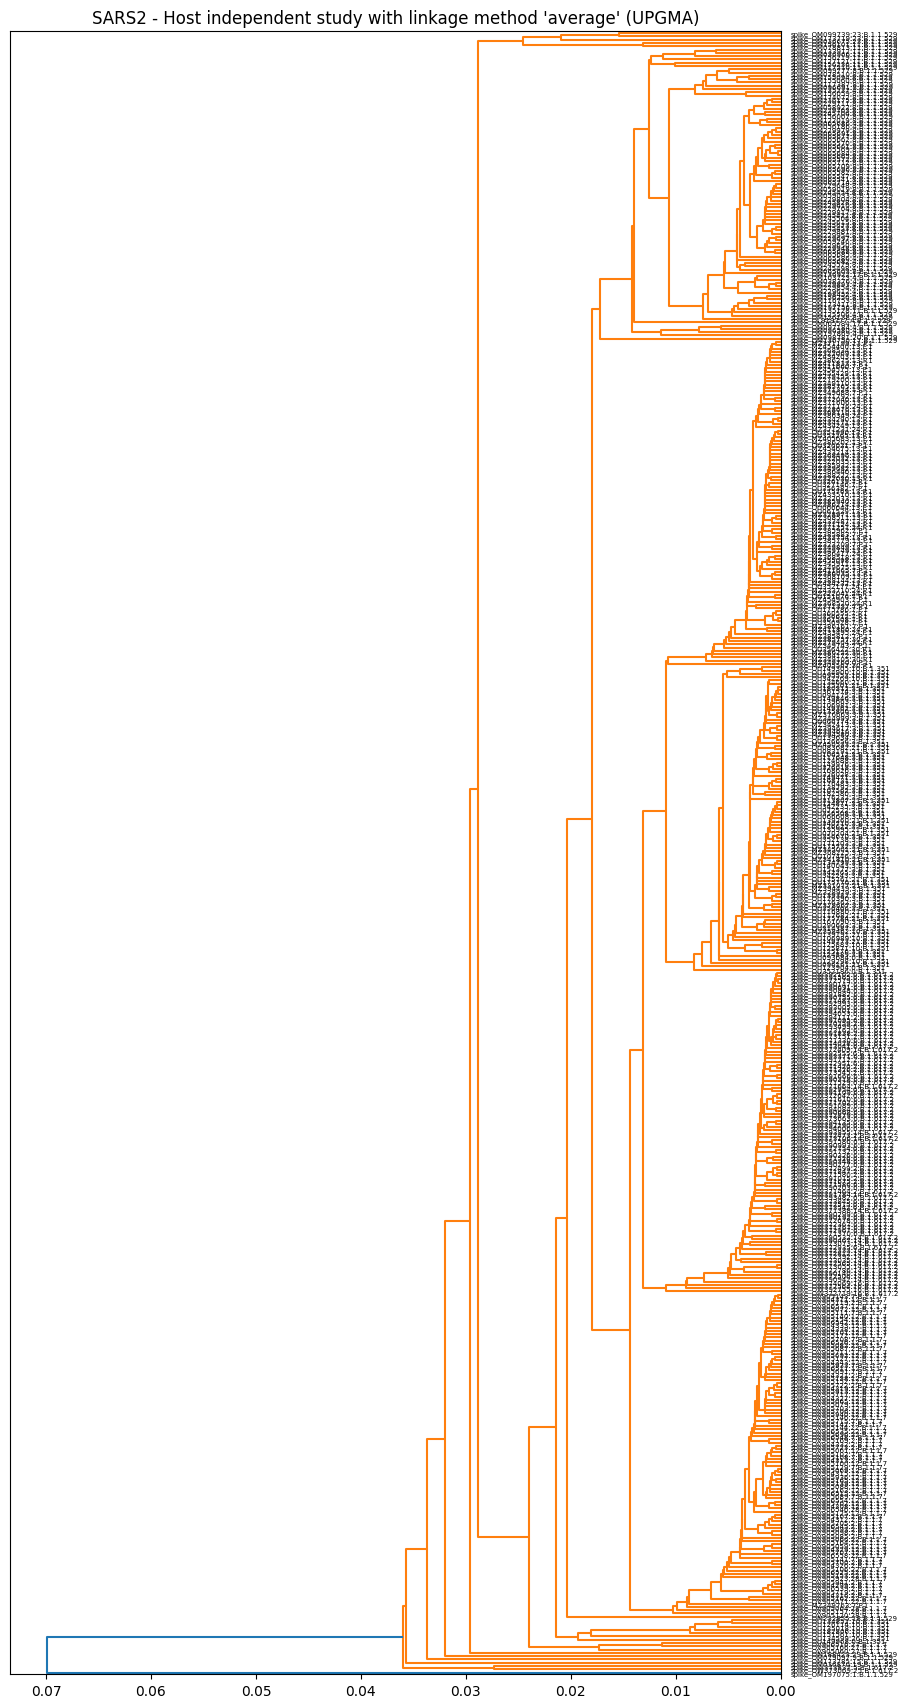

END


In [33]:
# Função para converter um ClusterNode em Newick
def get_newick(node, labels):
    if node.is_leaf():
        return labels[node.id]
    left = get_newick(node.left, labels)
    right = get_newick(node.right, labels)
    return f"({left},{right})"

# Função personalizada para obter a representação Newick com comprimento dos ramos
def get_newick_with_branch_length(node, lista_de_nomes):
    if node.is_leaf():
        return f"{lista_de_nomes[node.id]}:{node.dist}"
    else:
        esquerda = get_newick_with_branch_length(node.left, lista_de_nomes)
        direita = get_newick_with_branch_length(node.right, lista_de_nomes)
        return f"({esquerda},{direita}):{node.dist}"

# construindo arvores com distintos métodos de linkagem da scipy.cluster.hierarch.linkage
# mostrando onde os accessions foram parar sem analisar nem comparar
# para usar com tree_analyzer !!!!
ctr=0

working_labels = labels.copy()
short_labels = [label.split('|pacc:')[1] for label in working_labels]
short_labels = [label.split('|')[0] for label in short_labels]

# print("old: \n",short_labels)

nshort_labels=[]
for i in range(len(short_labels)):
    nshort_labels.append(Label4Tree[short_labels[i]])

for meth in methods:
    linkage_matrix = linkage(DistVec, meth)

    fig, ax = plt.subplots(1, 1, figsize=(10, 18))
    fig.set_size_inches(10, 18, forward=True)

    dn = dendrogram(linkage_matrix, ax=ax, labels=nshort_labels, \
                    show_leaf_counts=True, show_contracted=True, \
                    orientation='left',leaf_font_size=5)
    plt.title("SARS2 - Host independent study with linkage method '"+meth+"' ("+methodknownas[ctr]+")")

    plt.tight_layout(pad=4)
    plt.show()
    tree_name = 'tree_'+methodknownas[ctr]
    fig.savefig(tree_name+'.png', dpi=fig.dpi)

    ctr+=1


# MAURICIO - AQUI TEM QUE DAR UM JEITO DE SALVAR O DENDOGRAMA OU A LINKAGE MATRIX EM FORMATO NEWICK

    # E DEPOIS LER O ARQUIVO E PLOTAR PAR CONFERIR QUE FUNCIONA

#     # Converter a matriz de ligação em uma árvore hierárquica
#     tree = to_tree(linkage_matrix, rd=False)

#     # Salvar a árvore no formato Newick
#     with open(tree_name + '.newick', 'w') as f:
#         newick = get_newick(tree, nshort_labels)
#         f.write(newick + ";")

#     # Carregar a árvore a partir do arquivo Newick
#     tree = Tree(tree_name + '.newick', quoted_node_names=True)

#     # Criar um estilo para a plotagem da árvore (opcional)
#     ts = TreeStyle()
#     ts.show_leaf_name = True
#     ts.show_branch_length = True

#     # Plotar a árvore
#     tree.render(tree_name + ".png", tree_style=ts)

print("END")

# CRIANDO E EXPORTANDO ARVORE NEWICK USANDO UPGMA

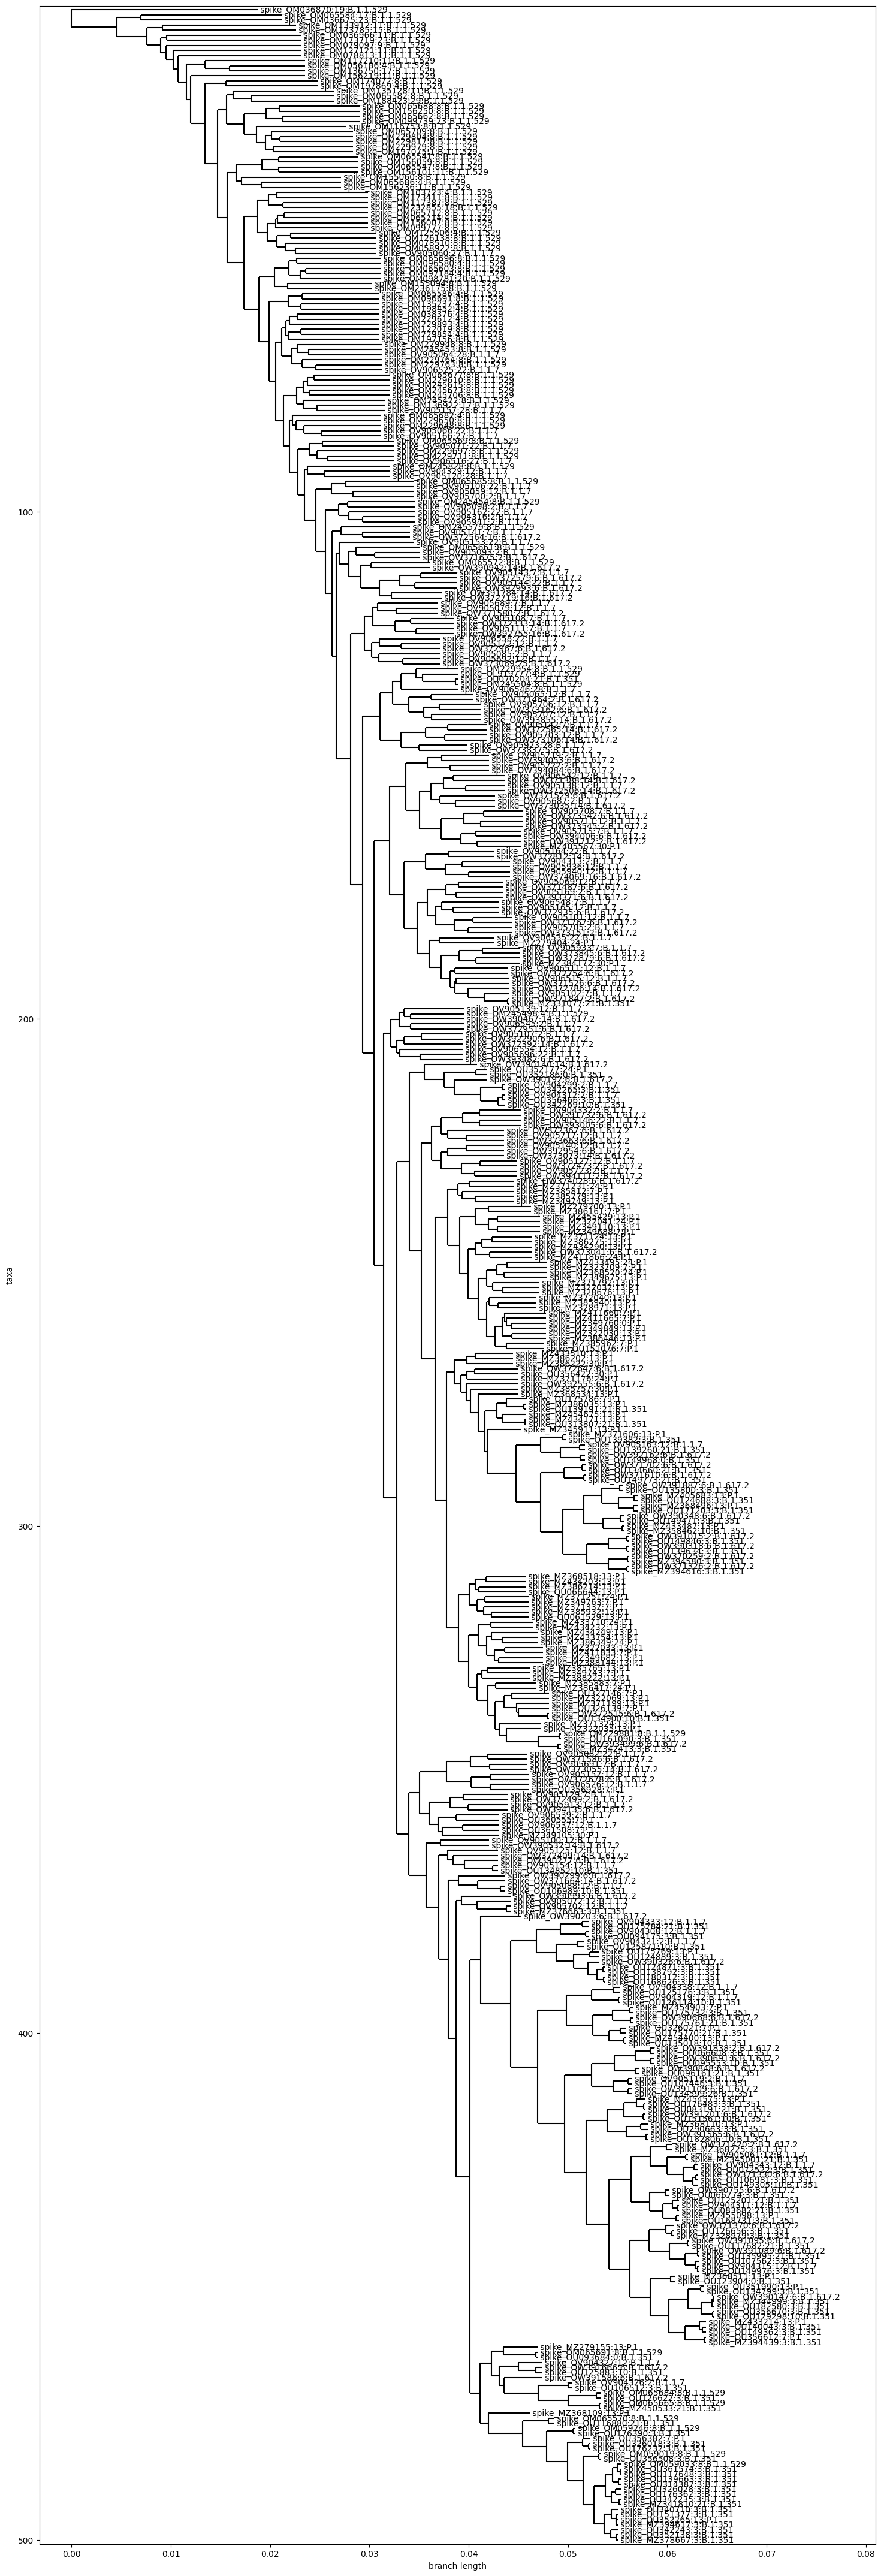

In [34]:
# MAURICIO - AQUI TENTEI DESSA FORMA MAS VEJA QUE A ARVORE ESTA CORROMPIDA, NAO SERVE

# CRIANDO E EXPORTANDO ARVORE NEWICK USANDO UPGMA

plt.rc('font', size=10)  # Substitua 12 pelo tamanho desejado

nLowLabels =[]
for i in range(len(LowLabels)):
    nLowLabels.append(Label4Tree[LowLabels[i]])

# Crie uma matriz de distâncias Biopython
dm = DistanceMatrix(nLowLabels, LowTriang)

# Use o construtor de árvore de distância UPGMA
constructor = DistanceTreeConstructor()
# tree_NJ = constructor.nj(dm)  # Substitua por 'nj' para usar o método Neighbor Joining
tree_UPGMA = constructor.upgma(dm)  # Substitua por 'nj' para usar o método Neighbor Joining

# Salve a árvore em formato Newick
# with open('arvore_NJ.nwk', 'w', encoding='utf-8') as f:
#     Phylo.write(tree_NJ, f, 'newick')

with open('arvore_UPGMA.nwk', 'w', encoding='utf-8') as f:
    Phylo.write(tree_UPGMA, f, 'newick')
# Plote a árvore (opcional)
# Crie uma figura com tamanho personalizado

# Crie uma figura com tamanho personalizado
fig, ax = plt.subplots(figsize=(18, 55))  # Ajuste o tamanho conforme desejado

# Plote a árvore
# Phylo.draw(tree_NJ, axes=ax, label_func=lambda x: '' if not x.is_terminal() else x.name)
Phylo.draw(tree_UPGMA, axes=ax, label_func=lambda x: '' if not x.is_terminal() else x.name)
# Exiba o gráfico
plt.show()


In [35]:
def print_model(model,n):
    print("name:", model.name)
    print("ListOfVarSites:\n",model.ListOfVarSites)
    print("NmbOfClasses:",model.NmbOfClasses)
    print("CodeOfClass[:",n,"]:\n",model.CodeOfClass[:n])
    print("GroundTruth[:",n,"]:\n",model.GroundTruth[:n])
    print("Accession[:",n,"]:\n",model.Accession[:n])
    print("repulsion:",model.repulsion)
    print("NmbOfClusters:",model.NmbOfClusters)
    print("TheSpeciesOfCluster:\n",model.TheSpeciesOfCluster)
    print("MinClusterAcc:",model.MinClusterResolution)
    print("Resolution:",model.Resolution)
    print("CLOPE repulsion parameter:",model.CLOPE_repulsion)
    print("DistributionMatrix:\n",model.DistributionMatrix)
    print("TheClusterOfClass:\n",model.TheClusterOfClass)


In [36]:
print_model(model,2)

name: SARS2-spike2
ListOfVarSites:
 [4, 5, 6, 8, 10, 11, 12, 15, 17, 18, 19, 21, 23, 24, 25, 26, 27, 28, 29, 31, 32, 35, 37, 44, 48, 51, 52, 53, 54, 55, 56, 59, 60, 61, 62, 63, 65, 66, 67, 68, 69, 72, 74, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 91, 92, 93, 94, 95, 96, 97, 98, 99, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 149, 150, 151, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 168, 169, 170, 171, 172, 173, 174, 175, 177, 180, 181, 182, 183, 184, 185, 188, 189, 190, 191, 192, 193, 194, 196, 197, 198, 202, 205, 208, 209, 210, 211, 214, 215, 216, 220, 221, 224, 225, 226, 233, 234, 235, 236, 239, 240, 241, 242, 243, 244, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 29

# CREATING THE GENE VARIANT FILE
## TO DO


In [ ]:
# creating and saving the final GVF file

# GVF=pd.DataFrame(model.CodeOfClass)
# col_rename_dict = {i:j for i,j in zip(GVF.columns,model.ListOfVarSites)}
# GVF.rename(columns=col_rename_dict, inplace=True)

# GVF['accession']=model.Accession
# GVF['ground_truth']=model.GroundTruth

# GVF

# GVF.to_csv(model.name+'.gvf')

In [ ]:
# print(GVF.columns)

In [ ]:
# saving and loading the  model

# Save the file
model_filename="model."+model.name+".obj"
dill.dump(model, file = open(model_filename, "wb"))

# Reload the file
loaded_model = dill.load(open(model_filename, "rb"))
print_model(loaded_model,2)

In [ ]:
# READY TO USE IN THE PRODUCTION PHASE - 23.10.2022